## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   294478 non-null  int64         
 1   date      294478 non-null  datetime64[ns]
 2   group     294478 non-null  object        
 3   purchase  294478 non-null  int64         
 4   price     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
# переводим в формат datetime
data['date'] = pd.to_datetime(data['date'])

In [6]:
# разделяем датасеты по группам А и В
data_a =  data[data['group'] == 'A']
data_b =  data[data['group'] == 'B']

In [7]:
# определяем даты начала и конца тестирования для каждой группы
test_dates = data.groupby('group')['date'].agg(['min', 'max'])
test_dates


,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


In [7]:
# определяем продолжительность тестирования для каждой группы
test_duration = test_dates['max'] - test_dates['min']
print(test_duration)


group
A   22 days
B   22 days
dtype: timedelta64[ns]


In [8]:
start_date = test_dates.loc['A', 'min']
end_date = test_dates.loc['A', 'max']


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [21]:
data_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147202 entries, 0 to 294476
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   147202 non-null  int64         
 1   date      147202 non-null  datetime64[ns]
 2   group     147202 non-null  object        
 3   purchase  147202 non-null  int64         
 4   price     147202 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 6.7+ MB


In [23]:
data_a.shape[0] + data_b.shape[0]

294478

In [25]:
data_a['user_id'].count()

147202

In [26]:
data_b['user_id'].count()

147276

In [27]:
data_a['purchase'].sum()

17723

In [28]:
data_b['purchase'].sum()

17514

In [29]:
data_a

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
4,864975,2021-01-21,A,1,150000
5,936923,2021-01-10,A,0,0
7,719014,2021-01-17,A,0,0
...,...,...,...,...,...
294471,718310,2021-01-21,A,0,0
294473,751197,2021-01-03,A,0,0
294474,945152,2021-01-12,A,0,0
294475,734608,2021-01-22,A,0,0


In [30]:
data_a['price'].sum()

1436260000

In [31]:
data_b['price'].sum()

1554100000

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [8]:
s_a = set(data_a['user_id'])
s_b = set(data_b['user_id'])

In [13]:
type(ll)

set

In [18]:
ss = (s_a.intersection(s_b))

In [19]:
len(ss)

1895

In [11]:
# Выберем пользователей, которые попали в обе тестовые группы
group_a_users = set(data[data['group'] == 'A']['user_id'])
group_b_users = set(data[data['group'] == 'B']['user_id'])
intersect_users = group_a_users.intersection(group_b_users)

if intersect_users:
    print(f"Количество пользователей, попавших в обе тестовые группы: {len(intersect_users)}")

    # Удалим дублирующие строки
    #data.drop_duplicates(subset='user_id', keep=False, inplace=True)

    # Удаляем пользователей, которые попали в обе группы
    for user_id in intersect_users:
        updated_data = updated_data[updated_data['user_id'] != user_id]
else:
    print("Нет пользователей, попавших в обе тестовые группы.")

updated_data.info()    


Количество пользователей, попавших в обе тестовые группы: 1895


NameError: name 'updated_data' is not defined

In [4]:
updated_data
# 286690 rows × 5 columns

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000
...,...,...,...,...,...
294473,751197,2021-01-03,A,0,0
294474,945152,2021-01-12,A,0,0
294475,734608,2021-01-22,A,0,0
294476,697314,2021-01-15,A,0,0


In [12]:
user_intersection = (s_a.intersection(s_b))

In [13]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

In [11]:
len(user_intersection)

1895

In [14]:
updated_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290688 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   290688 non-null  int64         
 1   date      290688 non-null  datetime64[ns]
 2   group     290688 non-null  object        
 3   purchase  290688 non-null  int64         
 4   price     290688 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 13.3+ MB


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [ ]:
updated_data = updated_data[updated_data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

In [12]:
updated_data.to_csv('data/updated_data.csv', index=False)

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

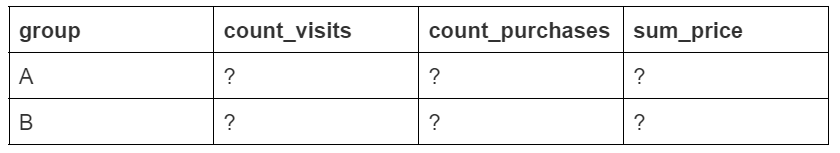
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

In [2]:
updated_data = pd.read_csv('data/updated_data.csv')

In [3]:
updated_data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [4]:
updated_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290688 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   290688 non-null  int64         
 1   date      290688 non-null  datetime64[ns]
 2   group     290688 non-null  object        
 3   purchase  290688 non-null  int64         
 4   price     290688 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 13.3+ MB


In [15]:
updated_data.to_parquet('data/updated_data.parquet')

In [2]:
updated_data = pd.read_parquet('data/updated_data.parquet')

In [3]:
updated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290688 entries, 0 to 290687
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   290688 non-null  int64 
 1   date      290688 non-null  object
 2   group     290688 non-null  object
 3   purchase  290688 non-null  int64 
 4   price     290688 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.1+ MB


In [4]:
upd_data_par.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [3]:
# ваш код здесь
updated_data_a = updated_data[updated_data['group'] == 'A']
updated_data_b = updated_data[updated_data['group'] == 'B']

In [4]:
updated_data_a['user_id'].count()
# 145307

145307

In [5]:
updated_data_b['user_id'].count()
# 145381

145381

количество совершённых покупок;

In [6]:
updated_data_a['purchase'].sum()

17487

In [7]:
updated_data_b['purchase'].sum()

17290

In [16]:
(updated_data_a['purchase']*updated_data_a['price']).sum()

1417780000

In [8]:
updated_data_b['purchase'].sum()

17290

сумма всех покупок в группе.

In [9]:
updated_data_a['price'].sum()
# 1417780000

1417780000

In [10]:
updated_data_b['price'].sum()
# 1533010000

1533010000

Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

ваши выводы здесь

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [11]:
# количество посещений в каждой группе
s_a = updated_data_a.shape[0]
s_b = updated_data_b.shape[0]

# количество покупок в каждой группе
pur_count_a = updated_data_a['purchase'].sum()
pur_count_b = updated_data_b['purchase'].sum()

# сумма покупок в каждой группе
price_sum_a = updated_data_a['price'].sum()
price_sum_b = updated_data_b['price'].sum()


In [12]:
# conversion — конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах)
round(((pur_count_a/s_a)*100),2)

12.03

In [13]:
round(((pur_count_b/s_b)*100),2)

11.89

In [14]:
# mean_check — средний чек (отношение суммы покупок к количеству покупок в каждой группе)
round(((price_sum_a/pur_count_a)),2)

81076.23

In [15]:
round(((price_sum_b/pur_count_b)),2)

88664.55

In [3]:
# Шаг 1: Разделение на группы
group_a = updated_data[updated_data['group'] == 'A']
group_b = updated_data[updated_data['group'] == 'B']

# Шаг 2: Расчет количества посещений и покупок в каждой группе
visits_a = len(group_a)
visits_b = len(group_b)
purchases_a = len(group_a[group_a['purchase'] == 1])
purchases_b = len(group_b[group_b['purchase'] == 1])
total_revenue_a = sum(group_a['price'])
total_revenue_b = sum(group_b['price'])

# Шаг 3: Расчет конверсии для каждой группы
conversion_a = purchases_a / visits_a * 100
conversion_b = purchases_b / visits_b * 100

# Шаг 4: Расчет среднего чека для каждой группы
mean_check_a = total_revenue_a / purchases_a
mean_check_b = total_revenue_b / purchases_b

# Вывод результатов
print("Конверсия группы A: {:.2f}%".format(conversion_a))
print("Конверсия группы B: {:.2f}%".format(conversion_b))
print("Средний чек группы A: {:.2f}".format(mean_check_a))
print("Средний чек группы B: {:.2f}".format(mean_check_b))

# Конверсия группы A: 12.03%
# Конверсия группы B: 11.89%
# Средний чек группы A: 81076.23
# Средний чек группы B: 88664.55

Конверсия группы A: 12.03%
Конверсия группы B: 11.89%
Средний чек группы A: 81076.23
Средний чек группы B: 88664.55


In [4]:
visits_a

145307

Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

ваши выводы здесь

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#data = pd.read_csv('data/ab_data_tourist.csv')

# Создаем сводную таблицу
pivot_table = updated_data.pivot_table(
    index='group', 
    columns='price', 
    values='purchase', 
    aggfunc='sum'
)

print(pivot_table)


price  0       10000   60000   100000  150000  200000
group                                                
A           0    5182    5271    1832    3478    1724
B           0    5201    1730    5227    3438    1694


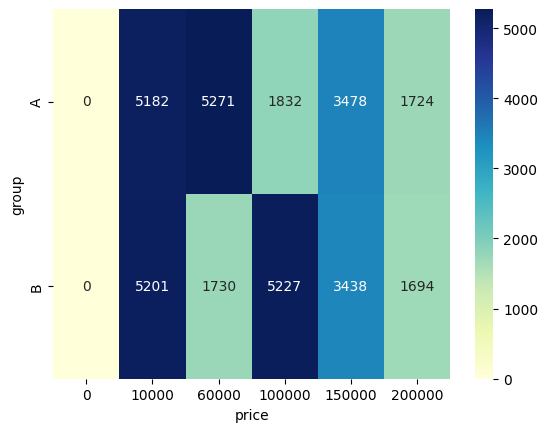

In [19]:
sns.heatmap(pivot_table, annot=True, fmt='g', cmap='YlGnBu')
plt.show()


In [21]:
sales_A = pivot_table.loc['A', 60000]
sales_B = pivot_table.loc['B', 60000]

print(f"Количество проданных туров за 60 000 рублей в группе A: {sales_A}")
print(f"Количество проданных туров за 60 000 рублей в группе B: {sales_B}")


Количество проданных туров за 60 000 рублей в группе A: 5271
Количество проданных туров за 60 000 рублей в группе B: 1730


## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [16]:
# ваш код здесь

(updated_data_a[updated_data_a['price'] == 60_000]).count()


user_id     5271
date        5271
group       5271
purchase    5271
price       5271
dtype: int64

In [17]:
(updated_data_b[updated_data_b['price'] == 60_000]).count()

user_id     1730
date        1730
group       1730
purchase    1730
price       1730
dtype: int64

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

In [ ]:
# ваш код здесь

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

ваши выводы здесь

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [5]:
import pandas as pd

#data = pd.read_csv('data/ab_data_tourist.csv')

# Группируем данные по дате и группе тестирования
grouped_data = updated_data.groupby(['date', 'group'])

# Вычисляем количество посещений страницы, количество покупок и сумму покупок
visits = grouped_data['user_id'].count()
purchases = grouped_data['purchase'].sum()
revenue = grouped_data['price'].sum()

# Вычисляем ежедневную конверсию и ежедневный средний чек
conversion = purchases / visits
average_check = revenue / purchases

# Создаем таблицу с результатами
result = pd.concat([visits, purchases, revenue, conversion, average_check], axis=1)
result.columns = ['visits', 'purchases', 'revenue', 'conversion', 'average_check']

# Выводим результаты
print(result)


                  visits  purchases   revenue  conversion  average_check
date       group                                                        
2021-01-02 A        2854        359  29410000    0.125788   81922.005571
           B        2861        345  29660000    0.120587   85971.014493
2021-01-03 A        6596        748  62000000    0.113402   82887.700535
           B        6619        754  65960000    0.113914   87480.106101
2021-01-04 A        6566        799  64250000    0.121687   80413.016270
           B        6536        764  68030000    0.116891   89044.502618
2021-01-05 A        6433        790  64550000    0.122804   81708.860759
           B        6511        749  63550000    0.115036   84846.461949
2021-01-06 A        6606        764  63410000    0.115652   82997.382199
           B        6751        838  75020000    0.124130   89522.673031
2021-01-07 A        6579        795  67290000    0.120839   84641.509434
           B        6616        767  67170000    0.

In [6]:
result.loc[('2021-01-03', 'A'), 'conversion']


0.1134020618556701

In [7]:
result.loc[('2021-01-03', 'B'), 'conversion']

0.11391448859344312

In [8]:
result.loc[('2021-01-03', 'A'), 'average_check']

82887.70053475935

In [9]:
result.loc[('2021-01-03', 'B'), 'average_check']

87480.10610079576

## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

In [2]:
updated_data = pd.read_parquet('data/updated_data.parquet')

In [3]:
updated_data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [4]:
daily_data = updated_data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,date,group,users_count,purchase,price
0,2021-01-02,A,2854,359,29410000
1,2021-01-02,B,2861,345,29660000
2,2021-01-03,A,6596,748,62000000
3,2021-01-03,B,6619,754,65960000
4,2021-01-04,A,6566,799,64250000


In [5]:
daily_data['conversion'] = round((daily_data['purchase']*100)/daily_data['users_count'],2)

In [6]:
daily_data.head()

,date,group,users_count,purchase,price,conversion
0,2021-01-02,A,2854,359,29410000,12.58
1,2021-01-02,B,2861,345,29660000,12.06
2,2021-01-03,A,6596,748,62000000,11.34
3,2021-01-03,B,6619,754,65960000,11.39
4,2021-01-04,A,6566,799,64250000,12.17


In [8]:
# Рассчитайте конверсию на каждый день по приведённой формуле. Результат занесите в столбец conversion. 
#Чему была равна конверсия (в процентах) в группе А 5 января 2017 года? Ответ округлите до второго знака после запятой.
daily_data.loc[(daily_data['date'] == '2021-01-20') & (daily_data['group'] == 'B'), 'conversion'].values[0]

11.82

In [10]:
# выделяем данные группы А
daily_data_a = daily_data[daily_data['group'] == 'A']
# считаем кумулятивное количество посетителей
daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()
# выводим время, количество посетителей и кумулятивное количество посетителей
display(daily_data_a[['date', 'users_count', 'cum_users_count']].head())

C:\Users\Asylum\AppData\Local\Temp\ipykernel_11724\1461240778.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()


,date,users_count,cum_users_count
0,2021-01-02,2854,2854
2,2021-01-03,6596,9450
4,2021-01-04,6566,16016
6,2021-01-05,6433,22449
8,2021-01-06,6606,29055


Это предупреждение возникает, потому что при выполнении операции присваивания daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum(), pandas не может точно определить, какие данные нужно изменить (исходный DataFrame или его копию). Чтобы избежать этой проблемы, можно воспользоваться методом .copy() при создании нового DataFrame для группы A:

Здесь мы создали копию daily_data_a, поэтому pandas будет точно знать, что нужно изменить кумулятивное количество только для этой копии. Предупреждение не должно появляться.

In [6]:
# выделяем данные группы А и создаем его копию
daily_data_a = daily_data[daily_data['group'] == 'A'].copy()

# считаем кумулятивное количество посетителей
daily_data_a['cum_users_count'] = daily_data_a['users_count'].cumsum()

# выводим время, количество посетителей и кумулятивное количество посетителей
display(daily_data_a[['date', 'users_count', 'cum_users_count']].head())


,date,users_count,cum_users_count
0,2021-01-02,2854,2854
2,2021-01-03,6596,9450
4,2021-01-04,6566,16016
6,2021-01-05,6433,22449
8,2021-01-06,6606,29055


In [7]:
# выделяем данные группы А и создаем его копию
daily_data_a = daily_data[daily_data['group'] == 'A'].copy()
daily_data_b = daily_data[daily_data['group'] == 'B'].copy()

# считаем кумулятивное количество посетителей
daily_data_a['cum_users_count'] = daily_data_a['users_count'].cumsum()
daily_data_b['cum_users_count'] = daily_data_b['users_count'].cumsum()

# считаем кумулятивное количество покупок
daily_data_a['cum_purchase'] = daily_data_a['purchase'].cumsum()
daily_data_b['cum_purchase'] = daily_data_b['purchase'].cumsum()

# считаем кумулятивную сумму покупок
daily_data_a['cum_price'] = daily_data_a['price'].cumsum()
daily_data_b['cum_price'] = daily_data_b['price'].cumsum()


# Вычисляем кумулятивную конверсию и кумулятивный средний чек
daily_data_a['cum_conversion'] = daily_data_a['cum_purchase'] / daily_data_a['cum_users_count']
daily_data_b['cum_conversion'] = daily_data_b['cum_purchase'] / daily_data_b['cum_users_count']

daily_data_a['cum_avg_check'] = daily_data_a['cum_price'] / daily_data_a['cum_purchase']
daily_data_b['cum_avg_check'] = daily_data_b['cum_price'] / daily_data_b['cum_purchase']

# выводим время, количество посетителей и кумулятивное количество посетителей
#display(daily_data_a[['date', 'users_count', 'cum_users_count','cum_purchase','cum_price','conversion']].head())
display(daily_data_a.head())

,date,group,users_count,purchase,price,conversion,cum_users_count,cum_purchase,cum_price,cum_conversion,cum_avg_check
0,2021-01-02,A,2854,359,29410000,12.58,2854,359,29410000,0.125788,81922.005571
2,2021-01-03,A,6596,748,62000000,11.34,9450,1107,91410000,0.117143,82574.525745
4,2021-01-04,A,6566,799,64250000,12.17,16016,1906,155660000,0.119006,81668.415530
6,2021-01-05,A,6433,790,64550000,12.28,22449,2696,220210000,0.120094,81680.267062
8,2021-01-06,A,6606,764,63410000,11.57,29055,3460,283620000,0.119084,81971.098266


In [25]:
# Какая кумулятивная конверсия была в группе B на 20 января 2021 года? Ответ приведите в процентах, округлив до сотых.
#group_b_data = daily_data_b[(daily_data_b['group'] == 'B') & (daily_data_b['date'] == '2021-01-20')]

cum_conversion_2021_01_20 = round(daily_data_b.loc[daily_data_b['date'] == '2021-01-20', 'cum_conversion'].values[0]*100, 2)

# Вычисляем кумулятивную конверсию в группе B на 20 января 2021 года и округляем до сотых
#cumulative_conversion_b = round(group_b_data['conversion'].values[0], 2)

print(f'Кумулятивная конверсия в группе B на 20 января 2021 года: {cum_conversion_2021_01_20}%')

Кумулятивная конверсия в группе B на 20 января 2021 года: 11.9%


In [24]:
# Какой кумулятивный средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

cum_avg_check_2021_01_12 = round(daily_data_a.loc[daily_data_a['date'] == '2021-01-12', 'cum_avg_check'].values[0], 0)

print(f'Кумулятивный средний чек в группе A на 12 января 2021 года: {cum_avg_check_2021_01_12} руб.')



Кумулятивный средний чек в группе A на 12 января 2021 года: 81492.0 руб.


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

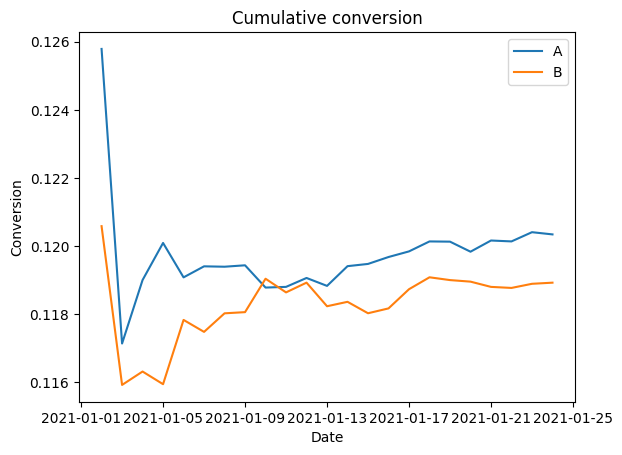

In [8]:
import matplotlib.pyplot as plt

# График кумулятивной конверсии
plt.plot(daily_data_a['date'], daily_data_a['cum_conversion'], label='A')
plt.plot(daily_data_b['date'], daily_data_b['cum_conversion'], label='B')
plt.legend()
plt.title('Cumulative conversion')
plt.xlabel('Date')
plt.ylabel('Conversion')
plt.show()




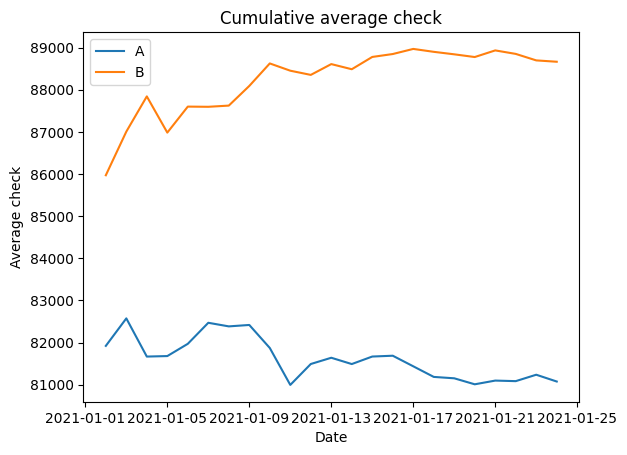

In [9]:
# График кумулятивного среднего чека
plt.plot(daily_data_a['date'], daily_data_a['cum_avg_check'], label='A')
plt.plot(daily_data_b['date'], daily_data_b['cum_avg_check'], label='B')
plt.legend()
plt.title('Cumulative average check')
plt.xlabel('Date')
plt.ylabel('Average check')
plt.show()

In [10]:
import matplotlib.pyplot as plt

# график кумулятивной конверсии
sns.lineplot(x='date', y='cum_conversion', hue='group', data=daily_data)
plt.title('Cumulative Conversion by Group')
plt.xlabel('Date')
plt.ylabel('Cumulative Conversion')
plt.show()




ValueError: Could not interpret value `cum_conversion` for parameter `y`

In [11]:
# график кумулятивного среднего чека
sns.lineplot(x='date', y='cum_avg_check', hue='group', data=daily_data)
plt.title('Cumulative Average Check by Group')
plt.xlabel('Date')
plt.ylabel('Cumulative Average Check')
plt.show()

ValueError: Could not interpret value `cum_avg_check` for parameter `y`

ваши выводы здесь

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [ ]:
# ваш код здесь

Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

ваши выводы здесь

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [ ]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

In [ ]:
ваши выводы здесь

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [ ]:
# ваш код здесь

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [ ]:
# ваш код здесь

 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

In [ ]:
ваши выводы здесь

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [ ]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

In [ ]:
ваши выводы здесь

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 